In [1]:
from pathlib import Path
from joblib import Memory
import h5py
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch, find_peaks, ricker, cwt
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

In [2]:
DATA_DIR = Path.cwd() / 'data/' # EMG signals
CACHE_DIR = Path.cwd() / 'cache/' # cache previously done computations (via joblib)

memory = Memory(CACHE_DIR)

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def notch(notch_freq, samp_freq, quality_factor=30):
    b, a = iirnotch(notch_freq, quality_factor, samp_freq)
    return b, a

def notch_filter(data, notch_fs, fs, q=30):
    b, a = notch(notch_fs, fs, q)
    y = filtfilt(b, a, data)
    return y

@memory.cache
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
    filt_out = np.zeros_like(data)
    for i in range(data.shape[0]):
        filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs, order=order), notch_fs, fs, notch_q)
    return filt_out


In [4]:
def loadmat(filename):
    file = h5py.File(filename, 'r')
    return np.asarray(file['grid_crds']), np.asarray(file['out_mat'])

if1_grid_crds, if1_out_mat = loadmat(DATA_DIR / r'increasing-force-1.mat')
if2_grid_crds, if2_out_mat = loadmat(DATA_DIR / r'increasing-force-2.mat')
sf1_grid_crds, sf1_out_mat = loadmat(DATA_DIR / r'steady-force-1.mat')

emg = if1_out_mat

In [5]:
print(emg.shape)

(60160, 64)


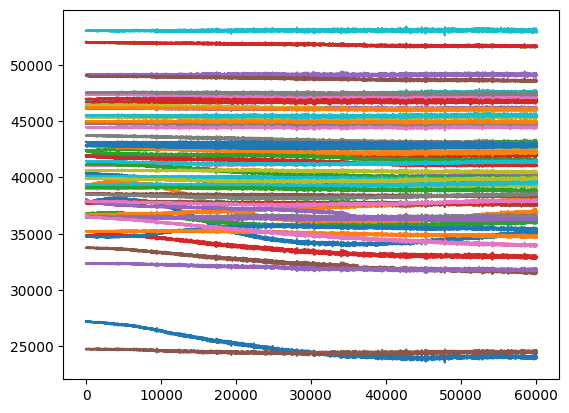

In [6]:
plt.plot(emg)
plt.show()

In [7]:
filtered_if1_out_mat = filt_GRID(emg.T).T

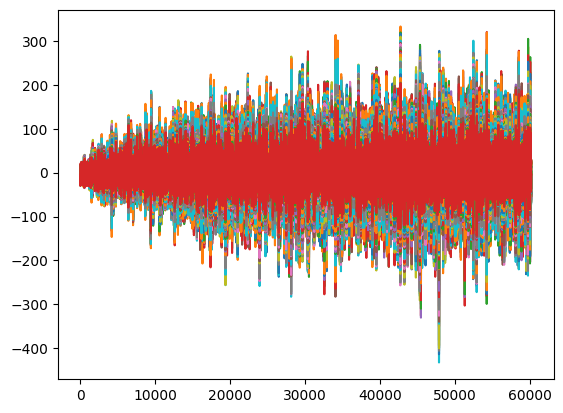

In [8]:
plt.plot(filtered_if1_out_mat)
plt.show()

In [9]:
fastica = FastICA(n_components=filtered_if1_out_mat.shape[1])
ica_fit = memory.cache(fastica.fit)

In [10]:
fastica_model = ica_fit(filtered_if1_out_mat)
IC = fastica_model.transform(filtered_if1_out_mat)
print(IC)

[[ 0.2056802   0.05403525 -0.5123971  ... -0.02832402 -0.19653965
  -0.0818984 ]
 [-0.07644441  0.3624015  -0.43463435 ... -0.19256352 -0.55573271
  -0.03464607]
 [-0.3181176   0.61819278 -0.4736462  ... -0.41328081 -0.93156148
  -0.0460144 ]
 ...
 [ 0.66137211 -0.60742453  0.50036611 ...  0.53946722 -0.04796153
  -0.24103525]
 [ 0.34699294 -0.5580289   0.24133906 ...  0.41581048 -0.00575279
  -0.1532612 ]
 [ 0.01394499 -0.20587416  0.01796992 ...  0.03516981  0.24109768
  -0.02042009]]


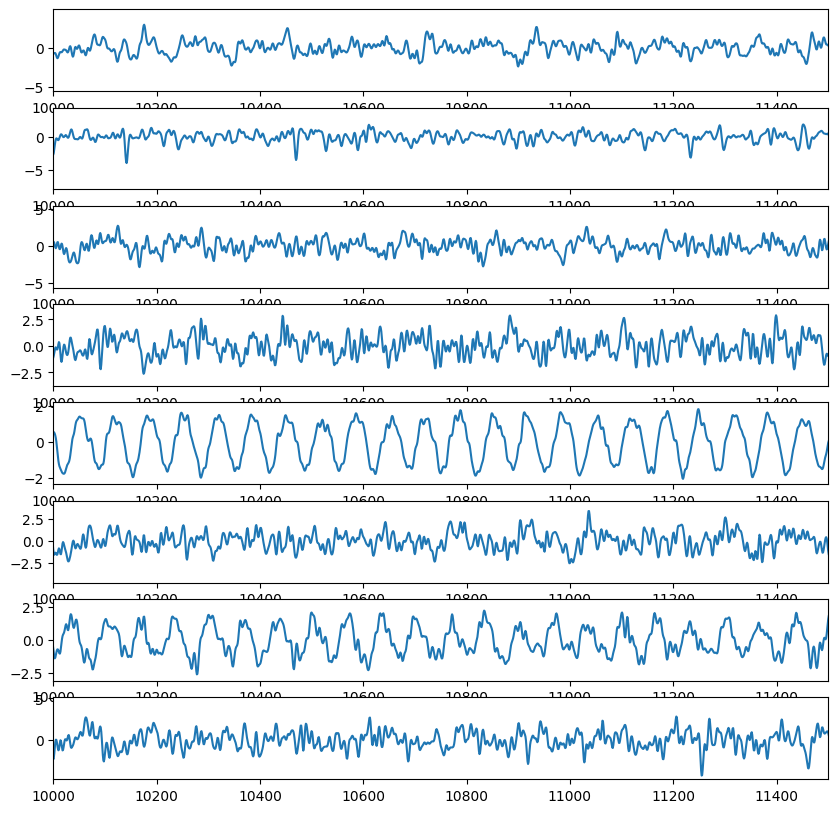

In [11]:
fig, ax = plt.subplots(nrows=IC.shape[1]//8, figsize=[10, 10])
for i in range(0, IC.shape[1]//8):
    ax[i].plot(IC[:, i])
    ax[i].set_xlim(left=10000, right=10000+1500)
plt.show()

In [12]:
# filtered_IC = butter_bandpass_filter(IC.T, lowcut=50, highcut=150, fs=4000).T

# fig, ax = plt.subplots(nrows=filtered_IC.shape[1]//8, figsize=[10, 10])
# for i in range(0, filtered_IC.shape[1]//8):
#     ax[i].plot(filtered_IC[:, i])
#     ax[i].set_xlim(left=10000, right=10000+1500)
# plt.show()

In [13]:
wavelet_convolved_IC = []
WIDTHS = np.arange(5, 25, 1)

for i in range(IC.shape[1]):
    wavelet_convolved_IC.append(cwt(IC[:, i], ricker, WIDTHS))

wavelet_convolved_IC = np.asarray(wavelet_convolved_IC)
wavelet_convolved_IC = np.moveaxis(wavelet_convolved_IC, [0, 1, 2], [0, 2, 1])
print(wavelet_convolved_IC.shape)

(64, 60160, 20)


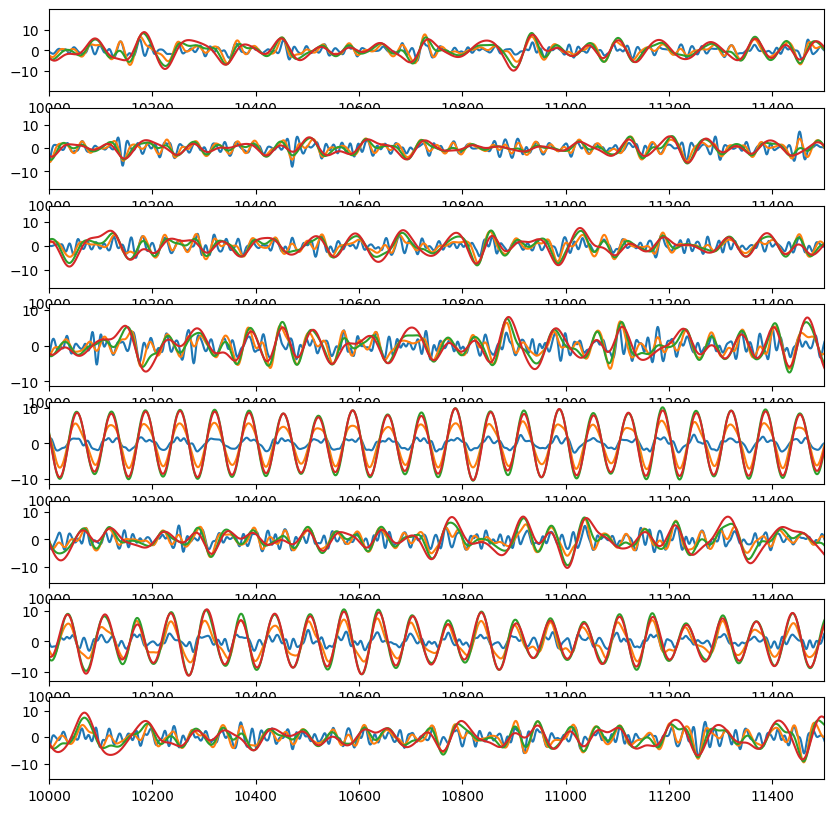

In [14]:
fig, ax = plt.subplots(nrows=wavelet_convolved_IC.shape[0]//8, figsize=[10, 10])
for i in range(0, wavelet_convolved_IC.shape[0]//8):
    ax[i].plot(wavelet_convolved_IC[i, :, ::5])
    ax[i].set_xlim(left=10000, right=10000+1500)
plt.show()

In [26]:
def nms(peaks, confs, temp_threshold) -> list[int]:
    keep_ids = []
    order_ids = np.argsort(-confs)
    for idx in order_ids:
        suppressed = False
        for keep_idx in keep_ids:
            if abs(peaks[keep_idx] - peaks[idx]) < temp_threshold:
                suppressed = True
                break
        if not suppressed:
            keep_ids.append(idx)
    return keep_ids

In [ ]:
firing_times = []

for i in range(wavelet_convolved_IC.shape[0]):
    ic_peaks = []
    ic_confs = []
    for j in range(wavelet_convolved_IC.shape[2]):
        sig = wavelet_convolved_IC[i, :, j]
        peaks, _ = find_peaks(sig)
        confs = sig[peaks]
        ic_peaks.extend(peaks)
        ic_confs.extend(confs)
    ic_peaks = np.asarray(ic_peaks)
    ic_confs = np.asarray(ic_confs)

    keep_ids = nms(ic_peaks, ic_confs, temp_threshold=50)
    keep_peaks = ic_peaks[keep_ids]
    keep_peaks = np.sort(keep_peaks)
    firing_times.append(keep_peaks)

In [28]:
with open('firing_times.txt', 'w') as file:
    for i in range(wavelet_convolved_IC.shape[0]):
        for firing_time in firing_times[i][:-1]:
            file.write(f'{firing_time},')
        file.write(f'{firing_times[-1][-1]}\n')